# Data pre-processing

### importing library

In [9]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
from google.colab.patches import cv2_imshow

In [10]:
train_df = pd.read_csv('/content/vinbigdata/train.csv')
train_df #image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN,2332,2580
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN,2954,3159
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN,2540,3072
...,...,...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN,2444,3200
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN,1994,2430
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN,2048,2500
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0,1968,2040


### Data 구성 확인

In [11]:
!ls /content/yolo_labels/labels/ | wc

  15000   15000  555000


In [12]:
!ls /content/vinbigdata/train/ | wc

  15000   15000  555000


In [13]:
!ls /content/vinbigdata/test/ | wc

   3000    3000  111000


In [14]:
len(train_df.image_id.unique())

15000

- 15,000장의 train dataset
- 3,000장의 test dataset

In [15]:
normal_sample = len(train_df[train_df.class_id == 14].image_id.unique())
print(f'정상인 sample 개수는: {normal_sample}')

정상인 sample 개수는: 10606


In [16]:
patient_sample = len(train_df[train_df.class_id != 14].image_id.unique())
print(f'patient sample 개수는: {patient_sample}')

patient sample 개수는: 4394


- 총 15,000개의 train dataset엔 10,606개의 정상인 sample이 있고
- patients sample은 총 4,394개로 구성되어 있다. 
(약 70%의 정상인, 30%의 patients)

정상인에는 label이 없기때문에 학습에 악 영향을 끼칠 것으로 생각되어 정상인 sample은 제외.

### class id 14번(normal) 지우기


In [17]:
train_df = train_df[train_df.class_id!=14].reset_index(drop = True) 
#reset_index: index를 reset시키는데 사용. drop을통해 index로 세팅한 열을 dataframe내에서 삭제할지 여부 결정
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0,2080,2336
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0,2304,2880
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0,2540,3072
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0,2285,2555
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0,2568,3353
...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0,2304,2880
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0,3072,3072
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0,2048,2500
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0,2304,2880


### 각 class당 sample 분포 확인

In [18]:
temp_df = train_df[['image_id', 'class_name', 'class_id']]
temp_df

,image_id,class_name,class_id
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8
...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13
36093,22672ab82c290c20b86863291e25ef6c,ILD,5
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9


In [19]:
# 각 class당 sample 개수 확인
temp_df.class_id.value_counts()

0     7162
3     5427
11    4842
13    4655
8     2580
7     2483
10    2476
9     2203
6     1247
5     1000
2      960
4      556
1      279
12     226
Name: class_id, dtype: int64

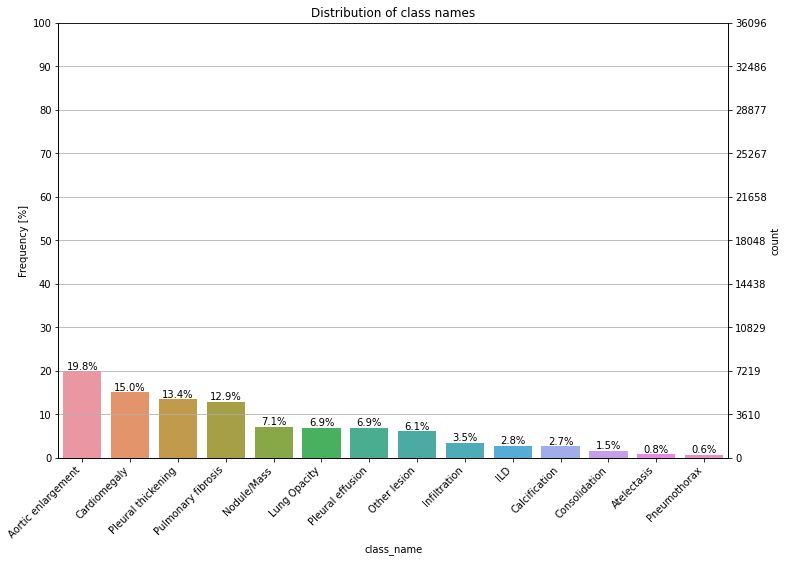

In [20]:
ncount = len(temp_df) #sample의 개수
plt.figure(figsize = (12,8))
#Seaborn으로 class name기준으로 bar chart 그리기
ax = sns.countplot(x = 'class_name', data = temp_df, order = temp_df.class_name.value_counts().index)
plt.title('Distribution of class names')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha ='right')
#x축만 공유하고 y축은 따로 쓰는 'twinx()'
ax2 = ax.twinx()
# tick: 축에 간격을 구분하기 위해 표시하는 눈금
# ax는 오른쪽, ax2는 왼쪽
ax2.yaxis.tick_left() 
ax.yaxis.tick_right() 

ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Frequency [%]')
# patches 모듈은 (x, y, width, height)의 형태로 도형으로 시각화 하는 방법
for p in ax.patches:
  x = p.get_bbox().get_points()[:,0] # get_points: bbox의 점을 [[x0,y0],[x1,y1]]형식의 numpy배열로 직접가져옴
  y = p.get_bbox().get_points()[1,1]
  # annotate: 주석달기. (주석 내용, 좌표는 필수로 전달해야함)
  # ha = horizontal alignmnet, va = vertical alignment
  ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha = 'center', va = 'bottom')

# linearlocator: min에서 max까지 균일 분포 눈금.
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
# y값의 limitation
ax2.set_ylim(0,100)
ax.set_ylim(0,ncount)
# multiplelocator: 눈금과 범위는 모두 base의 배수
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

ax2.grid(None)

### image size의 width&height이 동일하지 않기 때문에 각 수치들 normalization

In [ ]:
#x_min, y_min, x_max, y_max normalization값으로 update
train_df['x_min'] = train_df.apply(lambda row: (row.x_min) /row.width, axis =1)
train_df['y_min'] = train_df.apply(lambda row: (row.y_min) /row.height, axis =1)

train_df['x_max'] = train_df.apply(lambda row: (row.x_max) /row.width, axis =1)
train_df['y_max'] = train_df.apply(lambda row: (row.y_max) /row.height, axis =1)
#x_mid, y_mid가 추가
train_df['x_mid'] = train_df.apply(lambda row: (row.x_min + row.x_max)/2,axis =1)
train_df['y_mid'] = train_df.apply(lambda row: (row.y_min + row.y_max)/2, axis =1)
#normalization된 width & height 추가
train_df['w'] = train_df.apply(lambda row: (row.x_max - row.x_min), axis = 1)
train_df['h'] = train_df.apply(lambda row: (row.y_max - row.y_min), axis = 1)
#area 추가
train_df['area'] = train_df['w']*train_df['h']
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h,area
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,0.563462,0.686216,0.462500,0.195205,0.090283
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,0.623915,0.305903,0.150608,0.095833,0.014433
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,0.309843,0.128581,0.125984,0.024740,0.003117
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,0.773523,0.472407,0.368053,0.753033,0.277156
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,0.239875,0.721145,0.045950,0.039368,0.001809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,0.104167,0.538194,0.243924,0.694792,2304,2880,0.174045,0.616493,0.139757,0.156597,0.021886
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,0.378581,0.256185,0.435547,0.306315,3072,3072,0.407064,0.281250,0.056966,0.050130,0.002856
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,0.145996,0.265600,0.387695,0.603200,2048,2500,0.266846,0.434400,0.241699,0.337600,0.081598
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,0.002604,0.232639,0.118056,0.602778,2304,2880,0.060330,0.417708,0.115451,0.370139,0.042733


### 이미지 불러오는 편의를 위한 경로 추가하기

In [ ]:
path = '/content/vinbigdata/train/'
img_path = []
for i in train_df['image_id']:
  img_path.append(path+i+'.png')

train_df['img_path'] = img_path
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height,x_mid,y_mid,w,h,area,img_path
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,0.332212,0.588613,0.794712,0.783818,2080,2336,0.563462,0.686216,0.462500,0.195205,0.090283,/content/vinbigdata/train/9a5094b2563a1ef3ff50...
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,0.548611,0.257986,0.699219,0.353819,2304,2880,0.623915,0.305903,0.150608,0.095833,0.014433,/content/vinbigdata/train/051132a778e61a86eb14...
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,0.246850,0.116211,0.372835,0.140951,2540,3072,0.309843,0.128581,0.125984,0.024740,0.003117,/content/vinbigdata/train/1c32170b4af4ce1a3030...
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,0.589497,0.095890,0.957549,0.848924,2285,2555,0.773523,0.472407,0.368053,0.753033,0.277156,/content/vinbigdata/train/0c7a38f293d5f5e4846a...
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,0.216900,0.701461,0.262850,0.740829,2568,3353,0.239875,0.721145,0.045950,0.039368,0.001809,/content/vinbigdata/train/47ed17dcb2cbeec15182...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,0.104167,0.538194,0.243924,0.694792,2304,2880,0.174045,0.616493,0.139757,0.156597,0.021886,/content/vinbigdata/train/b53d1dd80e99ca6bcef9...
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,0.378581,0.256185,0.435547,0.306315,3072,3072,0.407064,0.281250,0.056966,0.050130,0.002856,/content/vinbigdata/train/26d1d5a0ef2e692c6340...
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,0.145996,0.265600,0.387695,0.603200,2048,2500,0.266846,0.434400,0.241699,0.337600,0.081598,/content/vinbigdata/train/22672ab82c290c20b868...
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,0.002604,0.232639,0.118056,0.602778,2304,2880,0.060330,0.417708,0.115451,0.370139,0.042733,/content/vinbigdata/train/db169d0be36123bd55b8...


### visualizing image and bboxes

(512, 512, 3)


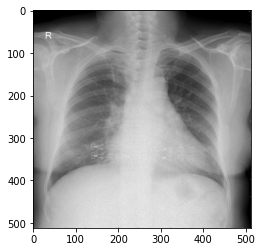

(512, 512, 3)


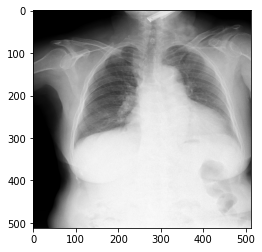

(512, 512, 3)


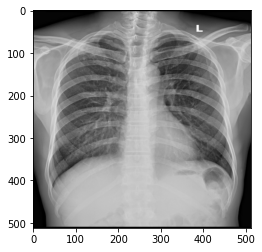

(512, 512, 3)


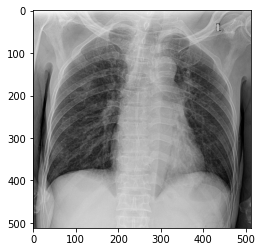

(512, 512, 3)


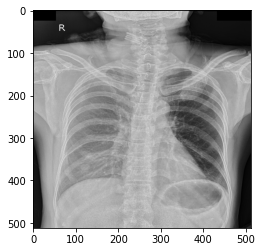

In [ ]:
for i in range(5): #5개의 sample만 확인
  img0 = cv2.imread(train_df.iloc[i].img_path)
  img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
  print(img0.shape)
  plt.imshow(img0)
  plt.show()

### Normalization된 값을 512 x 512 image size에 맞게 bbox 좌표 추가
- ori_x_min, ori_y_min, ori_x_max, ori_y_max, ori_x_mid, ori_y_mid, ori_w, ori_h

In [ ]:
train_df['ori_x_min'] = (train_df['x_min']*512).astype('int')
train_df['ori_y_min'] = (train_df['y_min']*512).astype('int')
train_df['ori_x_max'] = (train_df['x_max']*512).astype('int')
train_df['ori_y_max'] = (train_df['y_max']*512).astype('int')

train_df['ori_x_mid'] = (train_df['x_mid']*512).astype('int')
train_df['ori_y_mid'] = (train_df['y_mid']*512).astype('int')
train_df['ori_w'] = (train_df['w']*512).astype('int')
train_df['ori_h'] = (train_df['h']*512).astype('int')

In [ ]:
final_df = train_df.copy()
final_df = final_df[['image_id', 'class_name', 'class_id', 'ori_x_min', 'ori_y_min', 'ori_x_max', 'ori_y_max', 'ori_x_mid', 'ori_y_mid', 'ori_w', 'ori_h']]
final_df

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20
...,...,...,...,...,...,...,...,...,...,...,...
36091,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,53,275,124,355,89,315,71,80
36092,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,193,131,223,156,208,144,29,25
36093,22672ab82c290c20b86863291e25ef6c,ILD,5,74,135,198,308,136,222,123,172
36094,db169d0be36123bd55b866d6aa73983b,Other lesion,9,1,119,60,308,30,213,59,189


### sample 하나에 어떤식으로 bbox가 있는지 확인하기

In [ ]:
# sample 하나에 있는 bbox 정보 가져오기
temp_data = final_df[final_df['image_id'] == '9a5094b2563a1ef3ff50dc5c7ff71345']
temp_data = temp_data[['ori_x_min', 'ori_y_min', 'ori_x_max', 'ori_y_max']]
temp_data

,ori_x_min,ori_y_min,ori_x_max,ori_y_max
0,170,301,406,401
2899,440,378,461,436
13222,440,378,461,436
13809,170,301,407,394
22621,169,287,410,386
28361,258,156,319,211


In [ ]:
final_df[final_df.image_id == '9a5094b2563a1ef3ff50dc5c7ff71345']

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99
2899,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural effusion,10,440,378,461,436,450,407,21,57
13222,9a5094b2563a1ef3ff50dc5c7ff71345,Pleural thickening,11,440,378,461,436,450,407,21,57
13809,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,407,394,289,347,237,92
22621,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,169,287,410,386,289,337,240,98
28361,9a5094b2563a1ef3ff50dc5c7ff71345,Aortic enlargement,0,258,156,319,211,289,184,60,55


In [ ]:
temp_label = final_df[final_df.image_id == '9a5094b2563a1ef3ff50dc5c7ff71345'].class_id.tolist()

In [ ]:
bbox_list = [] #sample하나에 있는 bbox list를 넣어줌.
for i in range(len(temp_data)):
  bbox_list.append(temp_data.iloc[i].tolist())
bbox_list

[[170, 301, 406, 401],
 [440, 378, 461, 436],
 [440, 378, 461, 436],
 [170, 301, 407, 394],
 [169, 287, 410, 386],
 [258, 156, 319, 211]]

In [ ]:
bbox0 = np.array(bbox_list)
bbox0

array([[170, 301, 406, 401],
       [440, 378, 461, 436],
       [440, 378, 461, 436],
       [170, 301, 407, 394],
       [169, 287, 410, 386],
       [258, 156, 319, 211]])

In [ ]:
labels = np.array([temp_label])
labels

array([[ 3, 10, 11,  3,  3,  0]])

In [ ]:
len(labels), len(bbox_list)

(1, 6)

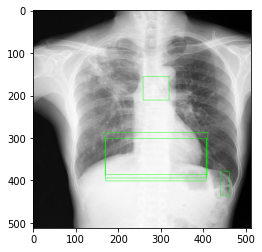

In [ ]:
img1 = cv2.imread(train_df.iloc[i].img_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_clone = np.copy(img1)
for i in range(len(bbox_list)):
  cv2.rectangle(img1_clone, (bbox0[i][0],bbox0[i][1]),(bbox0[i][2], bbox0[i][3]), color=(0, 255, 0), thickness=1)
plt.imshow(img1_clone)
plt.show()

Cardiomegaly, Aortic enlargement, Pleural effusion, Pleural thickening 을 표시하는 bbox들을 확인할 수 있다.